# Data

## Imports and Definitions

In [1]:
from torch.utils.data import Dataset, DataLoader
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

COCO2014_DATA_PATH = '../data/coco2014/'
WIKIART_DATA_PATH = '../data/wikiart/'
STYLE_PATH = '../data/style'

WIKIART_STYLE_MAP = {
    'Baroque': 1,
    'Cubism': 2,
    'Early_Renaissance': 3,
    'Pointillism': 4,
    'Ukiyo_e': 5,
}

WIKIART_STYLE_ONEHOT = F.one_hot(torch.arange(0, 5), num_classes=5)

## Data Pre-processing

In [ ]:
"""
Initial Data structure
/data
    /coco2014
        /annotations
        /images
            /test2014
            /train2014
            /val2014
        /labels
    /wikiart
        /Abstract_Expressionism
            /aaron-siskind_acolman-1-1955.jpg
            ...
        /Action_painting
        ...
        /Ukiyo_e
        /classes.csv
        /wclasses.csv
        
Target Data structure
/data
    /coco2014
        /annotations
        /images
            /test2014
            /train2014
            /val2014
        /labels
    /style
        /test
        /train
        /val
"""

#### a) Flatten WikiArt Dataset

In [ ]:
def flatten_data(include=['Cubism', 'Baroque', 'Early_Renaissance', 'Pointillism', 'Ukiyo_e'], src=WIKIART_DATA_PATH):
    """
    Given a directory src, unpack the contents of its sub-directories into the directory src. Only the names of the sub-directories in the 'include' list are unpacked
    """
    subdirs = [dir for dir in os.listdir(src) if os.path.isdir(os.path.join(src, dir)) and dir in include]

    for dir in subdirs:
        subdir_path = os.path.join(src, dir)
        files = os.listdir(subdir_path)
        loop = tqdm(files)
        loop.set_description(f'Unpacking sub-directory {dir}')
        for file in loop:
            # Prepend the style class the file is from
            os.rename(os.path.join(subdir_path, file), os.path.join(src, dir + '_' + file))
            
        os.rmdir(subdir_path)

In [ ]:
flatten_data()

#### b) Create WikiArt data splits

In [ ]:
def make_split(src, dest, files, ttv):
    """
    Write files from src to dest
    """
    loop = tqdm(files, total=len(files))
    loop.set_description(f"Writing {ttv} split")
    for file in loop:
        src_path = os.path.join(src, file)
        dest_path = os.path.join(dest, file)
        shutil.copyfile(src_path, dest_path)

def split_data(src, dest, split_size=0.8, max_files=30000, random_seed=42):
    """
    Given a directory src, create train, val, and test split directories in directory dest
    """
    random.seed(random_seed)
    if not (0 < split_size < 1):
        raise ValueError(f"split_size must be between 0 and 1. Got: {split_size}")
    
    all_files = [file for file in os.listdir(src) if file.endswith('.jpg')]
    
    if not all_files:
        raise ValueError(f"src directory did not contain any files")
    
    
    if len(all_files) > max_files:
        all_files = all_files[:max_files]
        
    random.shuffle(all_files)
        
    train_files, remaining_files = train_test_split(all_files, train_size=split_size, random_state=random_seed)
    
    validation_files, test_files = train_test_split(remaining_files, test_size=0.5, random_state=random_seed)
    
    # Make destination directories
    split = ['train', 'val', 'test']
    
    for ttv in split:
        split_path = os.path.join(dest, ttv)
        if os.path.exists(split_path):
            shutil.rmtree(split_path)
        
        os.makedirs(split_path, exist_ok=True)
        
    make_split(src, os.path.join(dest, 'train'), train_files, 'train')
    make_split(src, os.path.join(dest, 'val'), validation_files, 'val')
    make_split(src, os.path.join(dest, 'test'), test_files, 'test')
    

In [ ]:
split_data(WIKIART_DATA_PATH, STYLE_PATH, 0.8)

## Dataset and DataLoaders

In [2]:
class COCO2014(Dataset):
    def __init__(self, split, max_files, transform=None):
        if split not in ['train', 'val', 'test']:
            raise ValueError(f"split must be 'train', 'val', or 'test'. Got: {split}")
        
        split = split + '2014'
        self.image_path = os.path.join(COCO2014_DATA_PATH, 'images', split)
        images = os.listdir(self.image_path)
        
        if len(images) > max_files:
            images = images[:max_files]
        
        self.images = images
        self.length = len(images)
        self.transform = transform
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = Image.open(os.path.join(self.image_path, img_name)).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img

class StyleDataset(Dataset):
    def __init__(self, ttv, transform=None):
        self.image_path = os.path.join(STYLE_PATH, ttv)
        self.images = os.listdir(self.image_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img = Image.open(os.path.join(self.image_path, img_name)).convert('RGB')

        img_style = [s for s in img_name.split('_') if s[0].isupper() or (s[0] == 'e' and len(s) == 1)]
        label = WIKIART_STYLE_MAP["_".join(img_style)]

        if self.transform:
            img = self.transform(img)
            
        return img, label

In [3]:
import torchvision.transforms as transforms

train_tf = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomCrop(64),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [4]:
content_trainset = COCO2014('train', 24000, train_tf)
content_validset = COCO2014('val', 3000, val_tf)
style_trainset = StyleDataset('train', transform=train_tf)
style_validset = StyleDataset('val', transform=val_tf)

content_trainloader = DataLoader(content_trainset, 64, shuffle=True)
content_validloader = DataLoader(content_validset, 64, shuffle=False)
style_trainloader = DataLoader(style_trainset, 64, shuffle=True)
style_validloader = DataLoader(style_validset, 64, shuffle=False)

## Data Sources and Exploratory Analysis of Data

### Data Sources

The COCO 2014 Dataset on [Kaggle](https://www.kaggle.com/datasets/jeffaudi/coco-2014-dataset-for-yolov3/) is a popular dataset developed by [Lin et al.](https://arxiv.org/pdf/1405.0312) with 80 classes, 82,783 training and 40,504 validation images in RGB format. During image collection, the authors filtered out iconic images in favour of non-iconic images. Iconic images are characterised by single large objects in a canonical perspective centered in the image. Evidently, research from [Torralba and Efros](https://ieeexplore-ieee-org.wwwproxy1.library.unsw.edu.au/document/5995347) indicates that a lack of contextual information and non-canonical viewpoints in iconic images may lead to decreased generalization of datasets from capture bias and negative set bias. Therefore, by removing iconic images, the COCO dataset is well-generalised and provides rich contextual relationships between objects in their natural environments. For the task of image style transfer, the COCO 2014 dataset is an exceptional source for 'content' images. Chiefly, the prevalance of non-iconic images provide diverse structural features which challenge the robustness and efficacy of style transfer model performance. For example, models like AdaAttn and MAST hyper-fixate on local structure leading to style leakage [(Xu et al.)](https://arxiv.org/abs/2304.00414). Contributing to the diverse structural features is the breadth of object classes collected for this dataset which will challenge a model's ability to generalize.

The WikiArt Dataset accessed from [Kaggle](https://www.kaggle.com/datasets/steubk/wikiart) is dataset of 80,020 images from 1119 different artists with 27 distinct styles classes. The images are sourced from WikiArt.org, an encylopedia of art. Combined, the 27 styles classes offer a wide range of unique salient features ranging from the small visible brushstrokes of 'Impressionism', the vibrant and bold colouring of 'Fauvism' to visually blending of small dots of colour which define 'Pointillism'. For the task of image style transfer, the WikiArt dataset is a standard benchmark for 'style' images used across research. The large number of classes alongside the depth of salient features makes WikiArt useful in evaluating the robustness and reliability of transferring artistic styles while preserving style patterns. The quantity of style classes will negatively affect model performance as well as dramatically increase the cost of computation. Hence, we reduce the number of style classes we consider to five: Cubism, Pointillism, Baroque, Early_Renaissance, and Ukiyo_e. We have loosely selected these styles based on the criteria of uniqueness and within-class consistency of style.

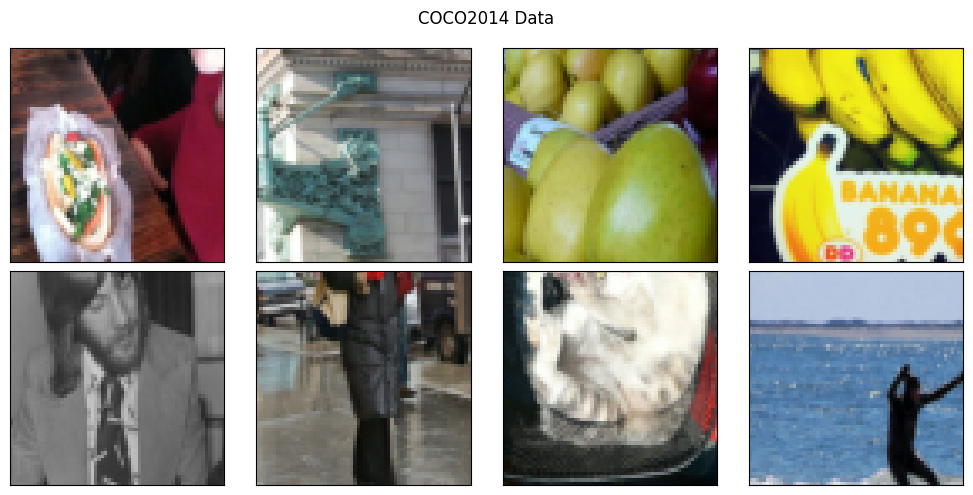

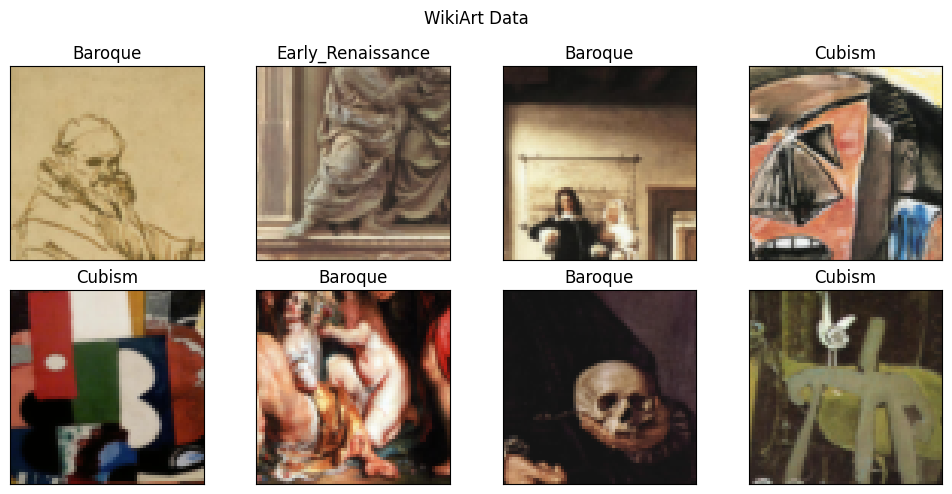

In [5]:
def plot_dataset(loader, title, styleset=False):
    """
    Plot images from a batch of a DataLoader
    Args:
        loader (iterable) - a Pytorch DataLoader class
    """
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
    for batch in loader:
        for i, ax in enumerate(axes.flat):
            if styleset:
                images, labels = batch
                label = list(WIKIART_STYLE_MAP.keys())[list(WIKIART_STYLE_MAP.values()).index(labels[i])]
                ax.set_title(label)
            else:
                images = batch
            image = images[i].permute(1, 2, 0)
            ax.imshow(image)
        break

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
plot_dataset(content_trainloader, 'COCO2014 Data')
plot_dataset(style_trainloader, 'WikiArt Data', styleset=True)

### Exploratory Data Analysis

#### Examining structural features using Canny and Sobel edge detection

Canny edge detection is an edge detection technique that extracts structural information from images. We utilise the function `skimage.feature.canny()` implemented in the scikit-image library to qualitatively display the structural features of images. The function uses the following steps:

1. A Gaussian blur with standard deviation of the Gaussian kernel equal to `sigma` to reduce image noise
2. Sobel edge detection
3. Apply non-maximum suppression to remove pixels far from edges 
4. Hysteresis thresholding is applied, labelling all points above the high threshold value as edges and recursively labelling any point above the low threshold value connected to a labeled point as an edge.

Sobel edge detection is a convolution-based method used for image edge detection that approximates the gradient of the image intensity. By convolving with the 3x3 Sobel kernel, the algorithm estimates the gradient magnitude and direction between regions of low and high intensity, hence, emphasising the edges of objects.

By comparing edges of the image output of the style transfer with its content image source, we qualitatively evaluate the change in structural features. Indicators of performant style transfer are consistent global structure between the output and content input images by examining object alignment and shape. Furthermore, small local details in the content image should not be ignored. 

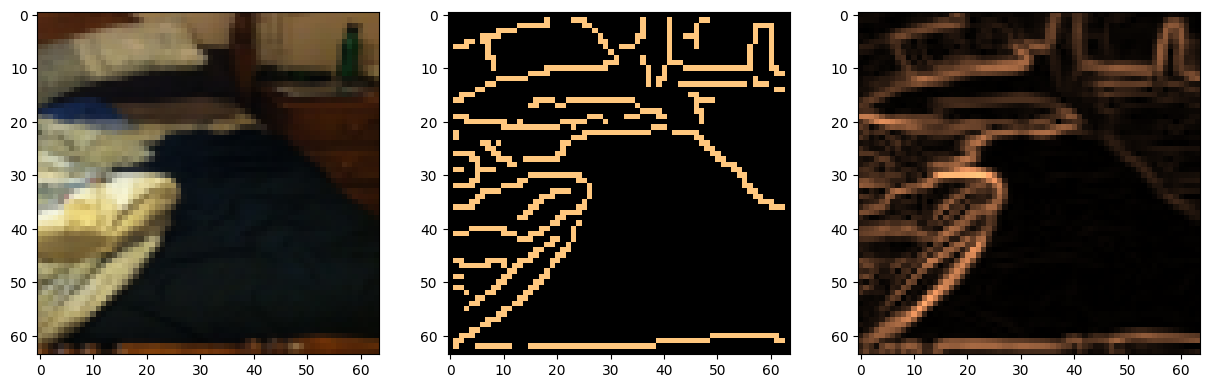

In [6]:
from skimage.feature import canny
from skimage.filters import sobel

# Get random image from content dataset
images = next(iter(content_trainloader))
random_index = random.randint(0, len(images) - 1)
img = images[random_index]

def plot_canny_edges(img, sigma=1):
  """
  Apply canny edge detection to the image with 'sigma' parameter
  """
  fig, ax = plt.subplots(1, 3, figsize=(15, 15))
  
  # Change view to (height, width, channels)
  img = img.permute(1, 2, 0)
  ax[0].imshow(img)
  
  # Convert tensor to numpy and single channel
  img = img.numpy()[:, :, 0]
  ax[1].imshow(canny(img, sigma=sigma), cmap="copper")
  
  ax[2].imshow(sobel(img), cmap="copper")

plot_canny_edges(img)

#### The characteristics and properties of styles

In this section, we explain the characteristics and properties of the five style classes selected as well as illustrate these images by plotting them without alteration from the original source.

In [7]:
def plot_style(style):
    """
    Plot four random images with the provided style in the train directory
    """
    style_images = [img for img in os.listdir(os.path.join(STYLE_PATH, 'train')) if img.startswith(style)]

    fig, axes = plt.subplots(1, 4, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
    fig.suptitle(f"Style - {style}", y=0.8)
    for i, img in enumerate(style_images[:4]):
        axes[i].imshow(Image.open(os.path.join(STYLE_PATH, 'train', img)).convert('RGB'))

    plt.show()

##### a) Cubism

Cubism, popularised by artists such as Pablo Picasso and Georges Braque in the 20th century is a style of art characterised by its use of interweaving planes and lines to depict abstract objects. Notably, Cubism art lacks form, and often, the arrangement of simple planes merges the foreground and background. Artworks in Cubism use muted tones of blacks and grays or use bright and solid colours. 

The Cubism class contains 2235 images.

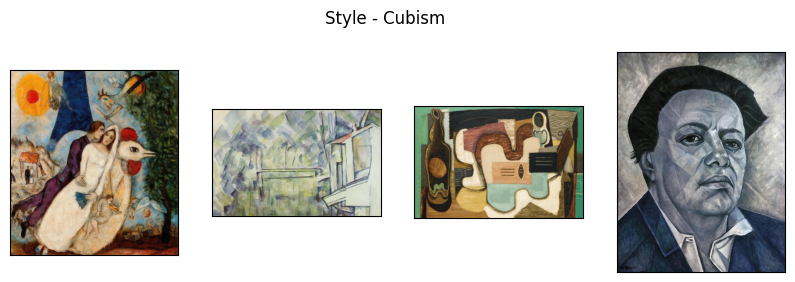

In [8]:
plot_style('Cubism')

##### b) Pointillism

Artworks in the style of Pointillism are defined by their distinct painting technique, utilising small dots of colour so that from a distance, they visually blend together to form a vibrant composition. 

The Pointillism class contains 513 images. 

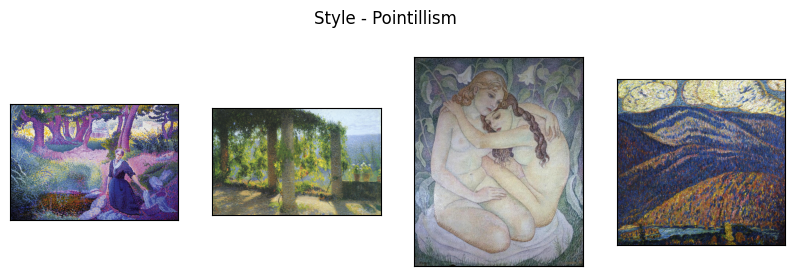

In [9]:
plot_style('Pointillism')

##### c) Baroque

The Baroque style refers to artworks derived from Europe from the early 17th to mid-18th century. Artworks of this style are associated with deep colors, dramatic light, sharp shadows, and dark backgrounds. 

The Baroque class contains 4240 images.

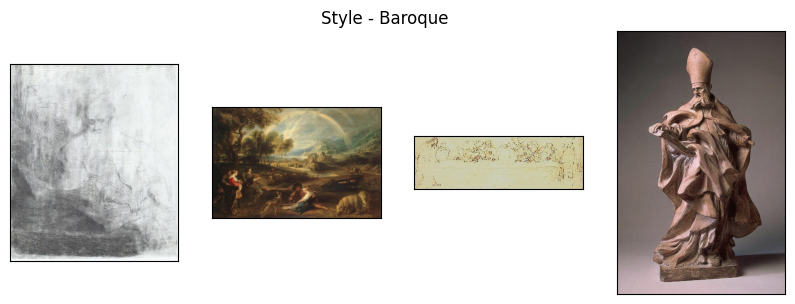

In [10]:
plot_style('Baroque')

##### d) Early Renaissance

Artworks in the Early Renaissance period are characterised by the realistic depiction of human anatomy and space from mythology and religion. The paintings of this period use muted colours whilst sculptures of human forms are made of bronze and marble. 

The Early Renaissance class contains 1391 images.  

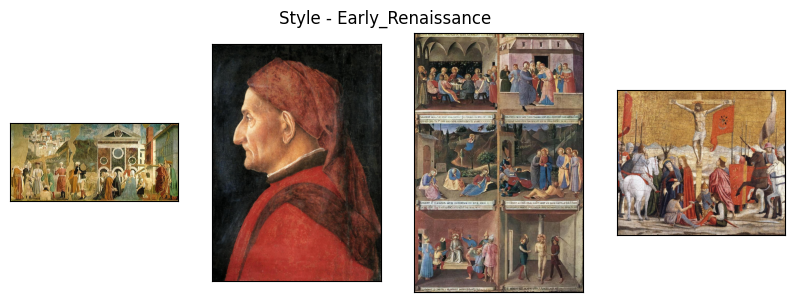

In [11]:
plot_style('Early_Renaissance')

##### e) Ukiyo-e

Ukiyo-e refers to a style of Japanese paintings and woodblock prints from the Edo period. The style is defined by its bold and flat brush strokes, asymmetric composition, and unusual graphical perspective. In stark contrast, the artwork is complimented by its colourfulness in depictions of flora and fauna. Furthermore, artworks of this style often contain text, written with black or red ink. The text stands prominently against the style's generous use of negative space as the artwork's background is often only painted with a single colour.

The Ukiyo-e class contains 1167 images.

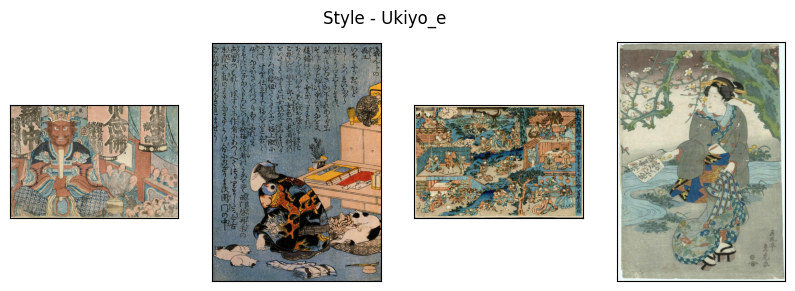

In [12]:
plot_style('Ukiyo_e')

#### Style class distribution

From this plot, we can see that our training dataset is heavily skewed, with many of the images coming from the Baroque style whereas there are less than 500 images for the Pointillism style. It is likely that the stylised images in the style of Baroque are closer to the expected style characteristics compared to styles where the model does not have many training samples. 

Text(0.5, 0, 'Style Class')

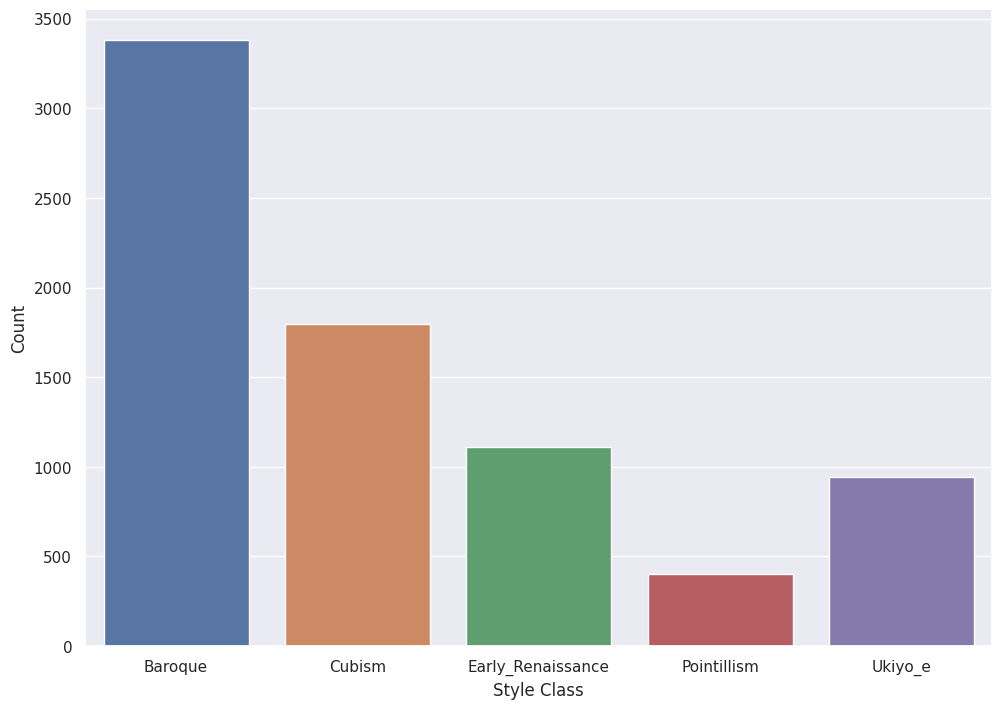

In [13]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

train_all_files = os.listdir(os.path.join('../data/style/train'))

style_frequency = {
    "Baroque": 0,
    "Cubism": 0,
    "Early_Renaissance": 0,
    "Pointillism": 0,
    "Ukiyo_e": 0,
}

for img_name in train_all_files:

    img_style = [s for s in img_name.split('_') if s[0].isupper() or (s[0] == 'e' and len(s) == 1)]
    img_style = "_".join(img_style)
    
    style_frequency[img_style] += 1

keys = list(style_frequency.keys())
vals = [style_frequency[k] for k in keys]

plot = sns.barplot(style_frequency, x=keys, y=vals, hue=keys)
plot.set_ylabel("Count")
plot.set_xlabel("Style Class")